<a href="https://colab.research.google.com/github/John-G-Thomas/DS-Unit-2-Applied-Modeling/blob/master/module1-define-ml-problems/LS_DS_231_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 3, Module 1*

---


# Define ML problems

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your decisions.

- [ ] Choose your target. Which column in your tabular dataset will you predict?
- [ ] Is your problem regression or classification?
- [ ] How is your target distributed?
    - Classification: How many classes? Are the classes imbalanced?
    - Regression: Is the target right-skewed? If so, you may want to log transform the target.
- [ ] Choose your evaluation metric(s).
    - Classification: Is your majority class frequency >= 50% and < 70% ? If so, you can just use accuracy if you want. Outside that range, accuracy could be misleading. What evaluation metric will you choose, in addition to or instead of accuracy?
    - Regression: Will you use mean absolute error, root mean squared error, R^2, or other regression metrics?
- [ ] Choose which observations you will use to train, validate, and test your model.
    - Are some observations outliers? Will you exclude them?
    - Will you do a random split or a time-based split?
- [ ] Begin to clean and explore your data.
- [ ] Begin to choose which features, if any, to exclude. Would some features "leak" future information?

If you haven't found a dataset yet, do that today. [Review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2) and choose your dataset.

Some students worry, ***what if my model isn't “good”?*** Then, [produce a detailed tribute to your wrongness. That is science!](https://twitter.com/nathanwpyle/status/1176860147223867393)

In [1]:
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

In [2]:
# General imports.
import category_encoders as ce
import itertools
import matplotlib.pyplot as plt
import pandas as pd
import pandas_profiling as pp
import numpy as np
import seaborn as sns
# Plotly imports.
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
# Scikit-learn imports.
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import OrdinalEncoder

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/John-G-Thomas/DS-Unit-2-Applied-Modeling/master/data/GlobalTemperatures%20(1).csv')
print(df.shape)
df.head()

(3192, 8)


,Unnamed: 0,LandAverageTemperatureUncertainty,UpperBounds,LowerBounds,month,year,Average_Temperature,Datetime
0,0,3.574,6.608,-0.540,1,1750,3.034,1750-01-01
1,1,3.702,6.785,-0.619,2,1750,3.083,1750-02-01
2,2,3.076,8.702,2.550,3,1750,5.626,1750-03-01
3,3,2.451,10.941,6.039,4,1750,8.490,1750-04-01
4,4,2.072,13.645,9.501,5,1750,11.573,1750-05-01


In [4]:
list(df.columns)

['Unnamed: 0',
 'LandAverageTemperatureUncertainty',
 'UpperBounds',
 'LowerBounds',
 'month',
 'year',
 'Average_Temperature',
 'Datetime']

### 1) Choose your target. Which column in your tabular dataset will you predict? - Regression -  Begin to clean and explore your data. and target

In [5]:
#Target average temperatures

In [6]:
def wrangle(df):
  df = df.copy()
  #Drop NaN and extra columns and index
  df.dropna(subset=['Average_Temperature'], inplace=True)
  df.set_index(pd.to_datetime(df['Datetime']), inplace = True)
  df.drop('Unnamed: 0', axis=1, inplace=True)
  df.drop('Datetime', axis=1, inplace=True)
  # Outliners
  df = df[(df['Average_Temperature'] >= np.percentile(df['Average_Temperature'], 0.5))
  &(df['Average_Temperature'] <= np.percentile(df['Average_Temperature'], 99.5))]
  # Split labels from feature matrix and target
  y = df['Average_Temperature']
  #Return
  return df, y

In [7]:
# Wrangling
X, y = wrangle(df)
print(X.shape)
X.head()

(3148, 6)


,LandAverageTemperatureUncertainty,UpperBounds,LowerBounds,month,year,Average_Temperature
Datetime,,,,,,
1750-01-01,3.574,6.608,-0.540,1,1750,3.034
1750-02-01,3.702,6.785,-0.619,2,1750,3.083
1750-03-01,3.076,8.702,2.550,3,1750,5.626
1750-04-01,2.451,10.941,6.039,4,1750,8.490
1750-05-01,2.072,13.645,9.501,5,1750,11.573


In [8]:
#X.drop('Datetime', axis=1, inplace=True)

In [9]:
X.isnull().sum()

LandAverageTemperatureUncertainty    0
UpperBounds                          0
LowerBounds                          0
month                                0
year                                 0
Average_Temperature                  0
dtype: int64

In [10]:
X.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3148 entries, 1750-01-01 to 2015-12-01
Data columns (total 6 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   LandAverageTemperatureUncertainty  3148 non-null   float64
 1   UpperBounds                        3148 non-null   float64
 2   LowerBounds                        3148 non-null   float64
 3   month                              3148 non-null   int64  
 4   year                               3148 non-null   int64  
 5   Average_Temperature                3148 non-null   float64
dtypes: float64(4), int64(2)
memory usage: 172.2 KB


In [11]:
X.describe()

,LandAverageTemperatureUncertainty,UpperBounds,LowerBounds,month,year,Average_Temperature
count,3148.000000,3148.000000,3148.000000,3148.000000,3148.000000,3148.000000
mean,0.913300,9.293713,7.467113,6.513977,1884.038119,8.380413
std,1.060012,4.233927,4.641216,3.449319,76.064469,4.313918
min,0.034000,0.988000,-5.965000,1.000000,1750.000000,-0.108000
25%,0.186000,5.399750,3.387000,4.000000,1819.000000,4.359750
50%,0.383000,9.397500,7.818000,6.500000,1884.000000,8.610500
75%,1.383000,13.351000,11.685500,10.000000,1950.000000,12.526250
max,7.880000,20.702000,15.277000,12.000000,2015.000000,15.462000


### 2) Choose which observations you will use to train, validate, and test your model

In [12]:
# Train test split based on time Industrial Revolution start of carbon emmision cutoff
cutoff = '1850-12-31'
X_train, y_train = X[X.index < cutoff], y[y.index < cutoff]
X_val, y_val = X[X.index >= cutoff], y[y.index >= cutoff]

# Baseline
y_train.value_counts(normalize=True)

3.213     0.002566
13.744    0.001711
13.556    0.001711
5.572     0.001711
13.293    0.001711
            ...   
5.061     0.000855
8.182     0.000855
11.788    0.000855
4.312     0.000855
14.750    0.000855
Name: Average_Temperature, Length: 1131, dtype: float64

In [13]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X.shape)
print(y.shape)

(1169, 6)
(1169,)
(1979, 6)
(1979,)
(3148, 6)
(3148,)


In [14]:
y

Datetime
1750-01-01     3.034
1750-02-01     3.083
1750-03-01     5.626
1750-04-01     8.490
1750-05-01    11.573
               ...  
2015-08-01    14.755
2015-09-01    12.999
2015-10-01    10.801
2015-11-01     7.433
2015-12-01     5.518
Name: Average_Temperature, Length: 3148, dtype: float64

### 2) Regression: Is the target right-skewed? If so, you may want to log transform the target.

In [15]:
# The distribution has improved, but is still skeved based on seasons of the year

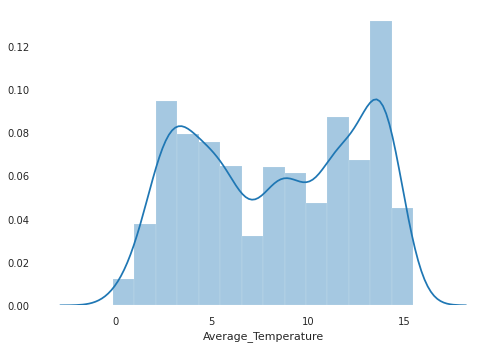

In [16]:
sns.distplot(y);

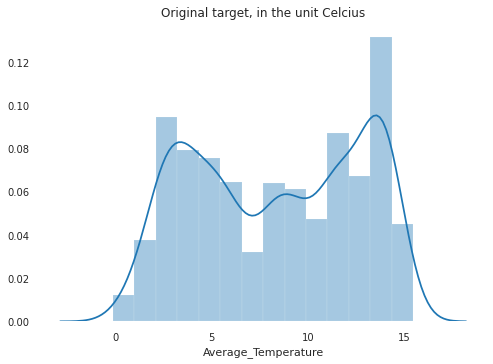

In [17]:
sns.distplot(y)
plt.title('Original target, in the unit Celcius');

In [18]:
#Based on log scal the data is skewed right

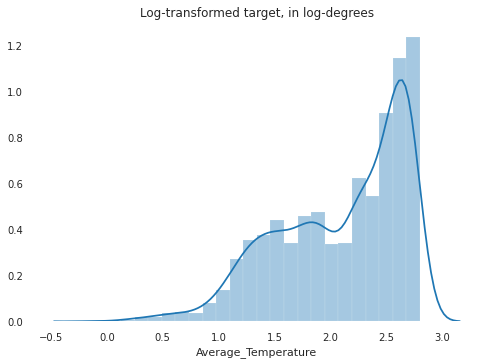

In [19]:
y_log = np.log1p(y)
sns.distplot(y_log)
plt.title('Log-transformed target, in log-degrees');

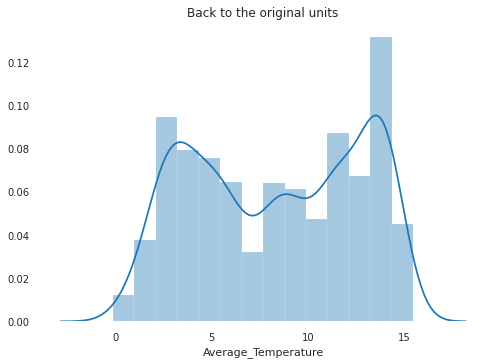

In [20]:
y_untransformed = np.expm1(y_log)
sns.distplot(y_untransformed)
plt.title('Back to the original units');

### 3) Choose your evaluation metric(s) - Regression: Will you use mean absolute error, root mean squared error, R^2, or other regression metrics?

In [34]:
# All the imports
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from category_encoders import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline

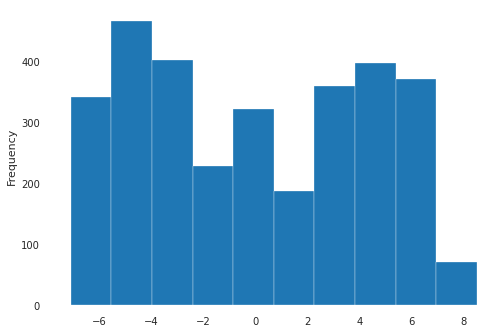

In [22]:
#Mean Absolute Error Baseline
average = y.mean()
MAE = average - y
MAE.plot(kind='hist');

In [23]:
MAE = MAE.abs().mean()
MAE

3.8444654325612078

In [24]:
#standard deviation

In [25]:
y.std()

4.31391807188852

In [29]:
list(df.columns)

['Unnamed: 0',
 'LandAverageTemperatureUncertainty',
 'UpperBounds',
 'LowerBounds',
 'month',
 'year',
 'Average_Temperature',
 'Datetime']

- linear Regressions

In [30]:
#make and train our model 
#initiate the class
model_2f =  LinearRegression()
#make features and target
features = ['year','month','LowerBounds','UpperBounds','LandAverageTemperatureUncertainty']
target = ['Average_Temperature']
#make train data
x_train = X[features]
y_train = X[target]
#fit the model 
model_2f.fit(x_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
# Select features - 1 Categorical Feature & 1  numeric features
features = ['Overall_Qual', 'Neighborhood']
target = 'SalePrice'

In [32]:
#test train data
train_pred = model_2f.predict(x_train)

In [ ]:
#Baseline R^2 Get better tgab 100% still getting 100% for some reason :(

In [33]:
r2 = r2_score(y_train,train_pred)
print(f' R2 score for train: {r2}')

 R2 score for train: 1.0
